# BERTScore Scoring Against NIST and Wikipedia

Duplicating CrisisFACTS 2022 assessment via BERTScore

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import json
import glob
import gzip

import scipy.stats

import matplotlib.pyplot as plt

In [3]:
import wikipedia

In [4]:
from torchmetrics.text.rouge import ROUGEScore

## Get CrisisFACTS Event Metadata

In [9]:
event_df = pd.read_json("CrisisFACTs-2022to2023.topics.json", lines=False).set_index("eventID")

### Get Summaries from Wikipedia

In [10]:
def get_wiki_summary(url):
    
    if "wikipedia.org" not in url:
        return ""
    
    page_title = url.rpartition("/")[-1]
    print(url)
    page = wikipedia.page(title=page_title, auto_suggest=False)
    
    return page.summary

event_df["wiki.summary"] = event_df["url"].apply(get_wiki_summary)

https://en.wikipedia.org/wiki/Lilac_Fire
https://en.wikipedia.org/wiki/Cranston_Fire
https://en.wikipedia.org/wiki/Holy_Fire_(2018)
https://en.wikipedia.org/wiki/Hurricane_Florence
https://en.wikipedia.org/wiki/2018_Maryland_flood
https://en.wikipedia.org/wiki/Saddleridge_Fire
https://en.wikipedia.org/wiki/Hurricane_Laura
https://en.wikipedia.org/wiki/Hurricane_Sally
https://en.wikipedia.org/wiki/2020_Beirut_explosion
https://en.wikipedia.org/wiki/2020_Houston_explosion
https://en.wikipedia.org/wiki/Edenville_Dam#Dam_failure
https://en.wikipedia.org/wiki/Hurricane_Dorian
https://en.wikipedia.org/wiki/Kincade_Fire
https://en.wikipedia.org/wiki/2020_Easter_tornado_outbreak
https://en.wikipedia.org/wiki/Tornado_outbreak_of_April_22-23,_2020
https://en.wikipedia.org/wiki/Tornado_outbreak_of_March_2-3,_2020


### Get Summaries from Assessors

In [11]:
with open("final-annotated-facts-results.json", "r") as in_file:
    annotation_data = json.load(in_file)

In [13]:
event_fact_lists = {}

for req_id,req_data in annotation_data.items():
    event_id = req_id.rpartition("-")[0]
    local_fact_set = {f[0] for f in req_data["fact_list"] if f[2] == "USEFUL_FACT"}
    
    with open("collapsed-event-days/Collapsed-%s.json" % req_id) as in_file:
        local_fact_data = json.load(in_file)
        
    local_fact_text = [
        fact["fact_text"] for fact in local_fact_data 
        if fact["collapsed_fact_id"] in local_fact_set
    ]
    
    local_fact_list = event_fact_lists.get(event_id, [])
    local_fact_list = local_fact_list + local_fact_text
    event_fact_lists[event_id] = local_fact_list

In [14]:
event_df["nist.summary"] = [". ".join(event_fact_lists[event_id]).replace("..", ".") for event_id in event_df.index]


## Save the Summaries

In [23]:
event_df.to_json("CrisisFACTs-2022to2023.topics.withSummaries.json")

In [15]:
# rouge = ROUGEScore(
#     use_stemmer=True,
# )

import bert_score
bert_score.__version__

'0.3.12'

In [16]:
TOP_K = 32

In [17]:
all_req_ids = list(annotation_data.keys())

In [18]:
submission_metrics = {}

for f in glob.glob("submissions/*.gz"):
    
    this_run_id = f.partition("/")[-1].replace(".gz", "")
    print(f, "-->", this_run_id)
    
    this_run_event_request_facts = {k:[] for k in all_req_ids}
    with gzip.open(f, "r") as in_file:
        for line_ in in_file:
            line = line_.decode("utf8")
            
            entry = json.loads(line)
            this_req_id = entry["requestID"]
            
            # We skip days where we have no relevant facts from assessors
            if this_req_id not in all_req_ids:
                continue
            
            this_run_event_request_facts[this_req_id].append(entry)
            
    local_event_summaries = {e_id:[] for e_id in event_df.index}
    for event_request,this_fact_list in this_run_event_request_facts.items():
        event_id = event_request.rpartition("-")[0]
        
        sorted_fact_list = sorted(this_fact_list, key=lambda v: v["importance"], reverse=True)
        this_day_summary = [this_top_fact["factText"] for this_top_fact in sorted_fact_list[:TOP_K]]
        
        local_event_summaries[event_id] = local_event_summaries[event_id] + this_day_summary
        

    wiki_dfs = []
    nist_dfs = []
    for event_id,event in event_df.iterrows():
        
        this_submitted_summary = local_event_summaries[event_id]

        this_summary_text = ". ".join(this_submitted_summary).replace("..", ".")
        print(event_id, len(this_summary_text))
        
        nist_summary = event["nist.summary"]
        wiki_summary = event["wiki.summary"]

        nist_metric_ = bert_score.score([this_summary_text], [nist_summary], model_type="microsoft/deberta-xlarge-mnli", device="cuda:0",)
        wiki_metric_ = bert_score.score([this_summary_text], [wiki_summary], model_type="microsoft/deberta-xlarge-mnli", device="cuda:0",)
        
        nist_metric = {
            "precision": nist_metric_[0],
            "recall": nist_metric_[1],
            "f1": nist_metric_[2],
        }
        
        wiki_metric = {
            "precision": wiki_metric_[0],
            "recall": wiki_metric_[1],
            "f1": wiki_metric_[2],
        }
        
        this_wiki_df = pd.DataFrame([{"metric":k, "value":v.item(), "event": event_id} for k,v in wiki_metric.items()])
        this_nist_df = pd.DataFrame([{"metric":k, "value":v.item(), "event": event_id} for k,v in nist_metric.items()])
        
        wiki_dfs.append(this_wiki_df)
        nist_dfs.append(this_nist_df)
        
    full_wiki_df = pd.concat(wiki_dfs)
    full_nist_df = pd.concat(nist_dfs)
    
    submission_metrics[this_run_id] = {
        "wiki": full_wiki_df,
        "nist": full_nist_df,
    }
    
    display(full_nist_df.groupby("metric").mean())



submissions/TorontoMU_Word2Vec_TFIDF.gz --> TorontoMU_Word2Vec_TFIDF
CrisisFACTS-001 26585
CrisisFACTS-002 20019
CrisisFACTS-003 21225
CrisisFACTS-004 56113
CrisisFACTS-005 13256
CrisisFACTS-006 13623
CrisisFACTS-007 7835
CrisisFACTS-008 26508
CrisisFACTS-009 17266
CrisisFACTS-010 14344
CrisisFACTS-011 26232


CrisisFACTS-012 20690


CrisisFACTS-013 17809
CrisisFACTS-014 16539
CrisisFACTS-015 16861
CrisisFACTS-016 11706
CrisisFACTS-017 11087
CrisisFACTS-018 13968


,value
metric,
f1,0.540790
precision,0.533584
recall,0.548500


submissions/IDACCS_occamsHybridGPT3.5.gz --> IDACCS_occamsHybridGPT3.5
CrisisFACTS-001 0


CrisisFACTS-002 0


CrisisFACTS-003 0


CrisisFACTS-004 0


CrisisFACTS-005 0


CrisisFACTS-006 0


CrisisFACTS-007 0


CrisisFACTS-008 0


CrisisFACTS-009 6875
CrisisFACTS-010 5204
CrisisFACTS-011 4800


CrisisFACTS-012 6642


CrisisFACTS-013 6040
CrisisFACTS-014 7870
CrisisFACTS-015 7408
CrisisFACTS-016 5212
CrisisFACTS-017 7039
CrisisFACTS-018 6303


,value
metric,
f1,0.361977
precision,0.363216
recall,0.361067


submissions/Siena.FactTrigrams1.gz --> Siena.FactTrigrams1
CrisisFACTS-001 41991
CrisisFACTS-002 29114
CrisisFACTS-003 34422
CrisisFACTS-004 78258
CrisisFACTS-005 20284
CrisisFACTS-006 21110
CrisisFACTS-007 10758
CrisisFACTS-008 42308
CrisisFACTS-009 61835
CrisisFACTS-010 44932
CrisisFACTS-011 46437


CrisisFACTS-012 44692


CrisisFACTS-013 47761
CrisisFACTS-014 61442
CrisisFACTS-015 63247
CrisisFACTS-016 21872
CrisisFACTS-017 33919
CrisisFACTS-018 31280


,value
metric,
f1,0.591902
precision,0.585613
recall,0.598463


submissions/Siena.WikiTrigrams2.gz --> Siena.WikiTrigrams2
CrisisFACTS-001 39813
CrisisFACTS-002 28459
CrisisFACTS-003 31892
CrisisFACTS-004 72298
CrisisFACTS-005 17869
CrisisFACTS-006 19543
CrisisFACTS-007 9573
CrisisFACTS-008 38672
CrisisFACTS-009 40757
CrisisFACTS-010 32575
CrisisFACTS-011 33287


CrisisFACTS-012 29271


CrisisFACTS-013 34523
CrisisFACTS-014 48930
CrisisFACTS-015 57390
CrisisFACTS-016 20897
CrisisFACTS-017 26149
CrisisFACTS-018 29611


,value
metric,
f1,0.586600
precision,0.579748
recall,0.593904


submissions/IRLabIITBHU_BM25_1.gz --> IRLabIITBHU_BM25_1
CrisisFACTS-001 37277
CrisisFACTS-002 24441
CrisisFACTS-003 25866
CrisisFACTS-004 58658
CrisisFACTS-005 15252
CrisisFACTS-006 16462
CrisisFACTS-007 7664
CrisisFACTS-008 30493
CrisisFACTS-009 28000
CrisisFACTS-010 16255
CrisisFACTS-011 22655


CrisisFACTS-012 14360


CrisisFACTS-013 20306
CrisisFACTS-014 20594
CrisisFACTS-015 23660
CrisisFACTS-016 11875
CrisisFACTS-017 11788
CrisisFACTS-018 15869


,value
metric,
f1,0.565542
precision,0.559206
recall,0.572384


submissions/drdqn-all.gz --> drdqn-all
CrisisFACTS-001 0


CrisisFACTS-002 0


CrisisFACTS-003 0


CrisisFACTS-004 0


CrisisFACTS-005 0


CrisisFACTS-006 0


CrisisFACTS-007 0


CrisisFACTS-008 0


CrisisFACTS-009 3514
CrisisFACTS-010 6933
CrisisFACTS-011 4465


CrisisFACTS-012 12533


CrisisFACTS-013 13831
CrisisFACTS-014 28167
CrisisFACTS-015 23466
CrisisFACTS-016 10893
CrisisFACTS-017 10527
CrisisFACTS-018 4630


,value
metric,
f1,0.337508
precision,0.342762
recall,0.332548


submissions/llama_13b_chat.gz --> llama_13b_chat
CrisisFACTS-001 0


CrisisFACTS-002 0


CrisisFACTS-003 0


CrisisFACTS-004 0


CrisisFACTS-005 0


CrisisFACTS-006 0


CrisisFACTS-007 0


CrisisFACTS-008 0


CrisisFACTS-009 31170
CrisisFACTS-010 26781
CrisisFACTS-011 22118


CrisisFACTS-012 24528


CrisisFACTS-013 25765
CrisisFACTS-014 31797
CrisisFACTS-015 32602
CrisisFACTS-016 20465
CrisisFACTS-017 26879
CrisisFACTS-018 27106


,value
metric,
f1,0.361143
precision,0.359668
recall,0.362750


submissions/Siena.WikiTrigrams1.gz --> Siena.WikiTrigrams1
CrisisFACTS-001 40285
CrisisFACTS-002 28388
CrisisFACTS-003 33123
CrisisFACTS-004 77412
CrisisFACTS-005 18004
CrisisFACTS-006 20043
CrisisFACTS-007 9624
CrisisFACTS-008 41819
CrisisFACTS-009 54262
CrisisFACTS-010 35917
CrisisFACTS-011 39825


CrisisFACTS-012 35993


CrisisFACTS-013 43433
CrisisFACTS-014 51146
CrisisFACTS-015 61718
CrisisFACTS-016 21535
CrisisFACTS-017 26681
CrisisFACTS-018 32653


,value
metric,
f1,0.593883
precision,0.589172
recall,0.599203


submissions/IDACCS_GPT3.5.gz --> IDACCS_GPT3.5
CrisisFACTS-001 0


CrisisFACTS-002 0


CrisisFACTS-003 0


CrisisFACTS-004 0


CrisisFACTS-005 0


CrisisFACTS-006 0


CrisisFACTS-007 0


CrisisFACTS-008 0


CrisisFACTS-009 5204
CrisisFACTS-010 5660
CrisisFACTS-011 8175


CrisisFACTS-012 4110


CrisisFACTS-013 4070
CrisisFACTS-014 6386
CrisisFACTS-015 6789
CrisisFACTS-016 3177
CrisisFACTS-017 2854
CrisisFACTS-018 6267


,value
metric,
f1,0.334037
precision,0.336661
recall,0.331648


submissions/V-TorontoMU-DFReeKLIM-v2.gz --> V-TorontoMU-DFReeKLIM-v2
CrisisFACTS-001 38211
CrisisFACTS-002 25337
CrisisFACTS-003 28998
CrisisFACTS-004 68530
CrisisFACTS-005 17287
CrisisFACTS-006 18938
CrisisFACTS-007 8878
CrisisFACTS-008 38373
CrisisFACTS-009 40874
CrisisFACTS-010 29330
CrisisFACTS-011 29439


CrisisFACTS-012 28820


CrisisFACTS-013 30914
CrisisFACTS-014 38345
CrisisFACTS-015 38604
CrisisFACTS-016 19421
CrisisFACTS-017 23597
CrisisFACTS-018 27344


,value
metric,
f1,0.568761
precision,0.556681
recall,0.581641


submissions/V-TorontoMU_USE_4.gz --> V-TorontoMU_USE_4
CrisisFACTS-001 17771
CrisisFACTS-002 14167
CrisisFACTS-003 15851
CrisisFACTS-004 44269
CrisisFACTS-005 6301
CrisisFACTS-006 9086
CrisisFACTS-007 4955
CrisisFACTS-008 18868
CrisisFACTS-009 9607
CrisisFACTS-010 8335
CrisisFACTS-011 9807


CrisisFACTS-012 8657


CrisisFACTS-013 9974
CrisisFACTS-014 9395
CrisisFACTS-015 9071
CrisisFACTS-016 7706
CrisisFACTS-017 7334
CrisisFACTS-018 9952


,value
metric,
f1,0.557066
precision,0.550564
recall,0.564009


submissions/IDACCS_occams_extract.gz --> IDACCS_occams_extract
CrisisFACTS-001 0


CrisisFACTS-002 0


CrisisFACTS-003 0


CrisisFACTS-004 0


CrisisFACTS-005 0


CrisisFACTS-006 0


CrisisFACTS-007 0


CrisisFACTS-008 0


CrisisFACTS-009 24569
CrisisFACTS-010 16662
CrisisFACTS-011 16781


CrisisFACTS-012 12912


CrisisFACTS-013 17659
CrisisFACTS-014 16973
CrisisFACTS-015 15810
CrisisFACTS-016 10186
CrisisFACTS-017 11643
CrisisFACTS-018 12149


,value
metric,
f1,0.333280
precision,0.330848
recall,0.336024


submissions/IRLabIITBHU_DFReeKLIM_2.gz --> IRLabIITBHU_DFReeKLIM_2
CrisisFACTS-001 39912
CrisisFACTS-002 27516
CrisisFACTS-003 29309
CrisisFACTS-004 71477
CrisisFACTS-005 17608
CrisisFACTS-006 19070
CrisisFACTS-007 10156
CrisisFACTS-008 38020
CrisisFACTS-009 43047
CrisisFACTS-010 32416
CrisisFACTS-011 31850


CrisisFACTS-012 29330


CrisisFACTS-013 31619
CrisisFACTS-014 54366
CrisisFACTS-015 45872
CrisisFACTS-016 22458
CrisisFACTS-017 25032
CrisisFACTS-018 24524


,value
metric,
f1,0.576681
precision,0.569420
recall,0.584415


submissions/baseline.v2.gz --> baseline.v2
CrisisFACTS-001 39912
CrisisFACTS-002 27516
CrisisFACTS-003 29468
CrisisFACTS-004 70746
CrisisFACTS-005 17653
CrisisFACTS-006 18822
CrisisFACTS-007 10018
CrisisFACTS-008 38869
CrisisFACTS-009 43294
CrisisFACTS-010 32382
CrisisFACTS-011 31850


CrisisFACTS-012 28628


CrisisFACTS-013 33715
CrisisFACTS-014 48274
CrisisFACTS-015 48625
CrisisFACTS-016 21294
CrisisFACTS-017 24999
CrisisFACTS-018 24632


,value
metric,
f1,0.580052
precision,0.573402
recall,0.587053


submissions/IRLabIITBHU_DFReeKLIM_1.gz --> IRLabIITBHU_DFReeKLIM_1
CrisisFACTS-001 39912
CrisisFACTS-002 27516
CrisisFACTS-003 29309
CrisisFACTS-004 70991
CrisisFACTS-005 17701
CrisisFACTS-006 19140
CrisisFACTS-007 10018
CrisisFACTS-008 38020
CrisisFACTS-009 46330
CrisisFACTS-010 32382
CrisisFACTS-011 31850


CrisisFACTS-012 28815


CrisisFACTS-013 34361
CrisisFACTS-014 53839
CrisisFACTS-015 46346
CrisisFACTS-016 22361
CrisisFACTS-017 24698
CrisisFACTS-018 25704


,value
metric,
f1,0.589606
precision,0.583676
recall,0.595911


submissions/drdqn-notopic.gz --> drdqn-notopic
CrisisFACTS-001 0


CrisisFACTS-002 0


CrisisFACTS-003 0


CrisisFACTS-004 0


CrisisFACTS-005 0


CrisisFACTS-006 0


CrisisFACTS-007 0


CrisisFACTS-008 0


CrisisFACTS-009 7119
CrisisFACTS-010 8044
CrisisFACTS-011 5778


CrisisFACTS-012 9234


CrisisFACTS-013 9606
CrisisFACTS-014 22172
CrisisFACTS-015 19089
CrisisFACTS-016 7756
CrisisFACTS-017 11054
CrisisFACTS-018 5346


,value
metric,
f1,0.336664
precision,0.342803
recall,0.330860


submissions/nm-gpt4.gz --> nm-gpt4
CrisisFACTS-001 23697
CrisisFACTS-002 16296
CrisisFACTS-003 16961
CrisisFACTS-004 46822
CrisisFACTS-005 11390
CrisisFACTS-006 12296
CrisisFACTS-007 6389
CrisisFACTS-008 24965
CrisisFACTS-009 23264
CrisisFACTS-010 18680
CrisisFACTS-011 19033


CrisisFACTS-012 15472


CrisisFACTS-013 19304
CrisisFACTS-014 23626
CrisisFACTS-015 21186
CrisisFACTS-016 12967
CrisisFACTS-017 15020
CrisisFACTS-018 16523


,value
metric,
f1,0.644664
precision,0.656740
recall,0.633320


submissions/baseline.v1.gz --> baseline.v1
CrisisFACTS-001 39950
CrisisFACTS-002 27894
CrisisFACTS-003 30468
CrisisFACTS-004 70945
CrisisFACTS-005 17428
CrisisFACTS-006 19022
CrisisFACTS-007 9858
CrisisFACTS-008 39283
CrisisFACTS-009 50438
CrisisFACTS-010 35800
CrisisFACTS-011 34513


CrisisFACTS-012 32038


CrisisFACTS-013 36497
CrisisFACTS-014 50775
CrisisFACTS-015 53240
CrisisFACTS-016 20981
CrisisFACTS-017 26977
CrisisFACTS-018 25388


,value
metric,
f1,0.590185
precision,0.586193
recall,0.594700


submissions/Siena.Baseline1.gz --> Siena.Baseline1
CrisisFACTS-001 41586
CrisisFACTS-002 28465
CrisisFACTS-003 33468
CrisisFACTS-004 75196
CrisisFACTS-005 19238
CrisisFACTS-006 20766
CrisisFACTS-007 9381
CrisisFACTS-008 41179
CrisisFACTS-009 55901
CrisisFACTS-010 40490
CrisisFACTS-011 40163


CrisisFACTS-012 37401


CrisisFACTS-013 42579
CrisisFACTS-014 43948
CrisisFACTS-015 61176
CrisisFACTS-016 22040
CrisisFACTS-017 30819
CrisisFACTS-018 31109


,value
metric,
f1,0.584385
precision,0.578054
recall,0.591193


submissions/Human_Info_Lab-FM-A.gz --> Human_Info_Lab-FM-A
CrisisFACTS-001 13484
CrisisFACTS-002 9604
CrisisFACTS-003 8827
CrisisFACTS-004 23217
CrisisFACTS-005 6745
CrisisFACTS-006 6534
CrisisFACTS-007 3347
CrisisFACTS-008 15229
CrisisFACTS-009 15324
CrisisFACTS-010 10203
CrisisFACTS-011 8464


CrisisFACTS-012 9884


CrisisFACTS-013 10079
CrisisFACTS-014 14690
CrisisFACTS-015 13997
CrisisFACTS-016 8788
CrisisFACTS-017 10092
CrisisFACTS-018 9784


,value
metric,
f1,0.596770
precision,0.599682
recall,0.594132


submissions/nm-gpt35-bm25.gz --> nm-gpt35-bm25
CrisisFACTS-001 17490
CrisisFACTS-002 12515
CrisisFACTS-003 14057
CrisisFACTS-004 36072
CrisisFACTS-005 8947
CrisisFACTS-006 9892
CrisisFACTS-007 5390
CrisisFACTS-008 19238
CrisisFACTS-009 16328
CrisisFACTS-010 13829
CrisisFACTS-011 14781


CrisisFACTS-012 14893


CrisisFACTS-013 15067
CrisisFACTS-014 17036
CrisisFACTS-015 15677
CrisisFACTS-016 9748
CrisisFACTS-017 10900
CrisisFACTS-018 11701


,value
metric,
f1,0.641839
precision,0.637864
recall,0.646025


submissions/Human_Info_Lab-FM-B.gz --> Human_Info_Lab-FM-B
CrisisFACTS-001 26860
CrisisFACTS-002 19499
CrisisFACTS-003 20696
CrisisFACTS-004 57026
CrisisFACTS-005 11908
CrisisFACTS-006 14862
CrisisFACTS-007 7637
CrisisFACTS-008 32013
CrisisFACTS-009 33621
CrisisFACTS-010 25342
CrisisFACTS-011 22593


CrisisFACTS-012 25997


CrisisFACTS-013 21900
CrisisFACTS-014 36714
CrisisFACTS-015 38607
CrisisFACTS-016 17172
CrisisFACTS-017 20318
CrisisFACTS-018 19632


,value
metric,
f1,0.613387
precision,0.612717
recall,0.614526


submissions/nm-gpt35.gz --> nm-gpt35
CrisisFACTS-001 18720
CrisisFACTS-002 14070
CrisisFACTS-003 15930
CrisisFACTS-004 42427
CrisisFACTS-005 8581
CrisisFACTS-006 9642
CrisisFACTS-007 6346
CrisisFACTS-008 22770
CrisisFACTS-009 16583
CrisisFACTS-010 16145
CrisisFACTS-011 13452


CrisisFACTS-012 16143


CrisisFACTS-013 20362
CrisisFACTS-014 22044
CrisisFACTS-015 16401
CrisisFACTS-016 12854
CrisisFACTS-017 10636
CrisisFACTS-018 16583


,value
metric,
f1,0.667777
precision,0.677180
recall,0.659015


submissions/V-TorontoMU_SBERT_Semanti.gz --> V-TorontoMU_SBERT_Semanti
CrisisFACTS-001 26713
CrisisFACTS-002 19534
CrisisFACTS-003 24344
CrisisFACTS-004 53787
CrisisFACTS-005 11998
CrisisFACTS-006 13355
CrisisFACTS-007 6244
CrisisFACTS-008 30328
CrisisFACTS-009 21533
CrisisFACTS-010 20832
CrisisFACTS-011 17758


CrisisFACTS-012 20356


CrisisFACTS-013 21967
CrisisFACTS-014 16327
CrisisFACTS-015 19617
CrisisFACTS-016 13138
CrisisFACTS-017 17550
CrisisFACTS-018 16362


,value
metric,
f1,0.586270
precision,0.584121
recall,0.588549


submissions/llama.gz --> llama
CrisisFACTS-001 66984
CrisisFACTS-002 40639
CrisisFACTS-003 42463
CrisisFACTS-004 101352
CrisisFACTS-005 32677
CrisisFACTS-006 32075
CrisisFACTS-007 16970
CrisisFACTS-008 66460
CrisisFACTS-009 49364
CrisisFACTS-010 50205
CrisisFACTS-011 36654


CrisisFACTS-012 40441


CrisisFACTS-013 41997
CrisisFACTS-014 59005
CrisisFACTS-015 57183
CrisisFACTS-016 34311
CrisisFACTS-017 45297
CrisisFACTS-018 30914


,value
metric,
f1,0.580545
precision,0.576552
recall,0.584758


submissions/ilp_mmr.gz --> ilp_mmr
CrisisFACTS-001 0


CrisisFACTS-002 0


CrisisFACTS-003 0


CrisisFACTS-004 0


CrisisFACTS-005 0


CrisisFACTS-006 0


CrisisFACTS-007 0


CrisisFACTS-008 0


CrisisFACTS-009 35592


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: be0effe2-5f33-470e-8b3a-859d69130bd9)')' thrown while requesting HEAD https://huggingface.co/microsoft/deberta-xlarge-mnli/resolve/main/tokenizer_config.json


CrisisFACTS-010 29972
CrisisFACTS-011 25701


CrisisFACTS-012 25623


CrisisFACTS-013 28681
CrisisFACTS-014 34242
CrisisFACTS-015 35013
CrisisFACTS-016 20091
CrisisFACTS-017 23706
CrisisFACTS-018 24346


,value
metric,
f1,0.322074
precision,0.317358
recall,0.327009


submissions/nut-kslab01.gz --> nut-kslab01
CrisisFACTS-001 39908
CrisisFACTS-002 27894
CrisisFACTS-003 30261
CrisisFACTS-004 67563
CrisisFACTS-005 16918
CrisisFACTS-006 18426
CrisisFACTS-007 9647
CrisisFACTS-008 37149
CrisisFACTS-009 54396
CrisisFACTS-010 35383
CrisisFACTS-011 34513


CrisisFACTS-012 31293


CrisisFACTS-013 36615
CrisisFACTS-014 34761
CrisisFACTS-015 50188
CrisisFACTS-016 20359
CrisisFACTS-017 23473
CrisisFACTS-018 27519


,value
metric,
f1,0.582812
precision,0.577414
recall,0.589304


In [ ]:
all_runs = []
for k,v in submission_metrics.items():
    print(k)
    
    stackable = []
    for comparator,ldf in v.items():
        stackable_ldf = ldf.copy()
        stackable_ldf["target.summary"] = comparator

        stackable.append(stackable_ldf)

    this_run_df = pd.concat(stackable)
    this_run_df["run"] = k
    
    all_runs.append(this_run_df)
    this_run_df.to_csv("evaluation.output.bertscore/%s.csv" % k, index=False)
    
all_runs_df = pd.concat(all_runs)
all_runs_df.to_csv("evaluation.output.bertscore/all_runs.csv", index=False)

In [ ]:
target_summaries = {}
for target in ["wiki", "nist"]:
    this_target_df = all_runs_df[all_runs_df["target.summary"] == target]
    
    index = []
    rows = []
    for run_name,group in this_target_df.groupby("run"):
        print(run_name)
        this_row = group.pivot("event", "metric", "value").mean()
        rows.append(this_row)
        index.append(run_name)

    summary_df = pd.DataFrame(rows, index=index)[[
        "f1", 
    ]]

    final_df = summary_df.sort_values(by="f1", ascending=False)
    final_df.to_csv("evaluation.output.bertscore/%s.summary.csv" % target)
    
    target_summaries[target] = final_df

In [8]:
rel2023_events = [
    'CrisisFACTS-009',
    'CrisisFACTS-010',
    'CrisisFACTS-011',
    'CrisisFACTS-012',
    'CrisisFACTS-013',
    'CrisisFACTS-014',
    'CrisisFACTS-015',
    'CrisisFACTS-016',
    'CrisisFACTS-017',
    'CrisisFACTS-018'

]

In [ ]:
rows = []
for runtag,group in all_runs_df[all_runs_df["event"].isin(rel2023_events)].groupby("run"):
    print(runtag)
    t_map = {"run": runtag}
    for target,t_group in group.groupby("target.summary"):
        print("\t", target)
        
        if target == "wiki":
            t_group = t_group[~t_group["event"].isin(["CrisisFACTS-011", "CrisisFACTS-012"])]
        for metric,m_group in t_group.groupby("metric"):
            print("\t\t", metric, m_group["value"].mean())
            
            t_map["%s.%s" % (target,metric)] = m_group["value"].mean()
            
    rows.append(t_map)

In [ ]:
by_run_df = pd.DataFrame(rows).set_index("run")
by_run_df.to_csv("by_run.bertscore.summary.csv")
by_run_df[["nist.f1", "wiki.f1"]]

In [49]:
by_run_df[["nist.f1", "wiki.f1"]].corr()

,nist.f1,wiki.f1
nist.f1,1.000000,0.729993
wiki.f1,0.729993,1.000000


<AxesSubplot:xlabel='nist.f1', ylabel='wiki.f1'>

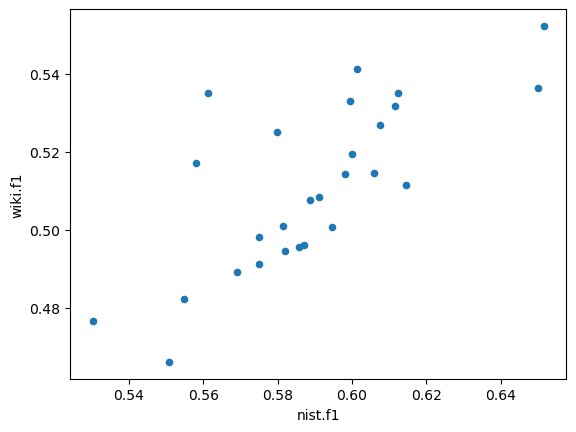

In [50]:
by_run_df[["nist.f1", "wiki.f1"]].plot.scatter(x="nist.f1", y="wiki.f1")

In [ ]:
fig = plt.figure(figsize=(9,16))
ax = fig.add_subplot(1,1,1)

by_run_df[["nist.f1", "wiki.f1"]].sort_values(by="nist.f1").plot.barh(ax=ax)

## By Day

In [9]:
rows = []
for event,group in all_runs_df[all_runs_df["event"].isin(rel2023_events)].groupby("event"):
    print(event)
    t_map = {"event": event}
    for target,t_group in group.groupby("target.summary"):
        print("\t", target)
        
        if target == "wiki":
            t_group = t_group[~t_group["event"].isin(["CrisisFACTS-011", "CrisisFACTS-012"])]
        for metric,m_group in t_group.groupby("metric"):
            print("\t\t", metric, m_group["value"].mean())
            
            t_map["%s.%s" % (target,metric)] = m_group["value"].mean()
            
    rows.append(t_map)

CrisisFACTS-009
	 nist
		 f1 0.5944958119480698
		 precision 0.5838032254466304
		 recall 0.6062390738063388
	 wiki
		 f1 0.5243068491971051
		 precision 0.500296613684407
		 recall 0.5517989452238437
CrisisFACTS-010
	 nist
		 f1 0.5397375226020813
		 precision 0.5372185475296445
		 recall 0.5428161797700105
	 wiki
		 f1 0.5075077348285251
		 precision 0.48013112169724925
		 recall 0.5384173349097923
CrisisFACTS-011
	 nist
		 f1 0.584928779690354
		 precision 0.5842972949699119
		 recall 0.5856975140394988
	 wiki
CrisisFACTS-012
	 nist
		 f1 0.5417604424335338
		 precision 0.5370358758502536
		 recall 0.5467083575548949
	 wiki
CrisisFACTS-013
	 nist
		 f1 0.6086270566339846
		 precision 0.609467124497449
		 recall 0.6080218663922062
	 wiki
		 f1 0.5076530321880623
		 precision 0.4749550521373749
		 recall 0.5454533055976585
CrisisFACTS-014
	 nist
		 f1 0.6521245086634601
		 precision 0.6584827281810619
		 recall 0.6463503064932646
	 wiki
		 f1 0.497006070834619
		 precision 0.495349497

In [10]:
by_event_df = pd.DataFrame(rows).set_index("event")
by_event_df.to_csv("by_event.bertscore.summary.csv")
by_event_df[["nist.f1", "wiki.f1"]]

,nist.f1,wiki.f1
event,,
CrisisFACTS-009,0.594496,0.524307
CrisisFACTS-010,0.539738,0.507508
CrisisFACTS-011,0.584929,NaN
CrisisFACTS-012,0.541760,NaN
CrisisFACTS-013,0.608627,0.507653
CrisisFACTS-014,0.652125,0.497006
CrisisFACTS-015,0.591514,0.535723
CrisisFACTS-016,0.588953,0.498277
CrisisFACTS-017,0.576741,0.500104


<AxesSubplot:ylabel='event'>

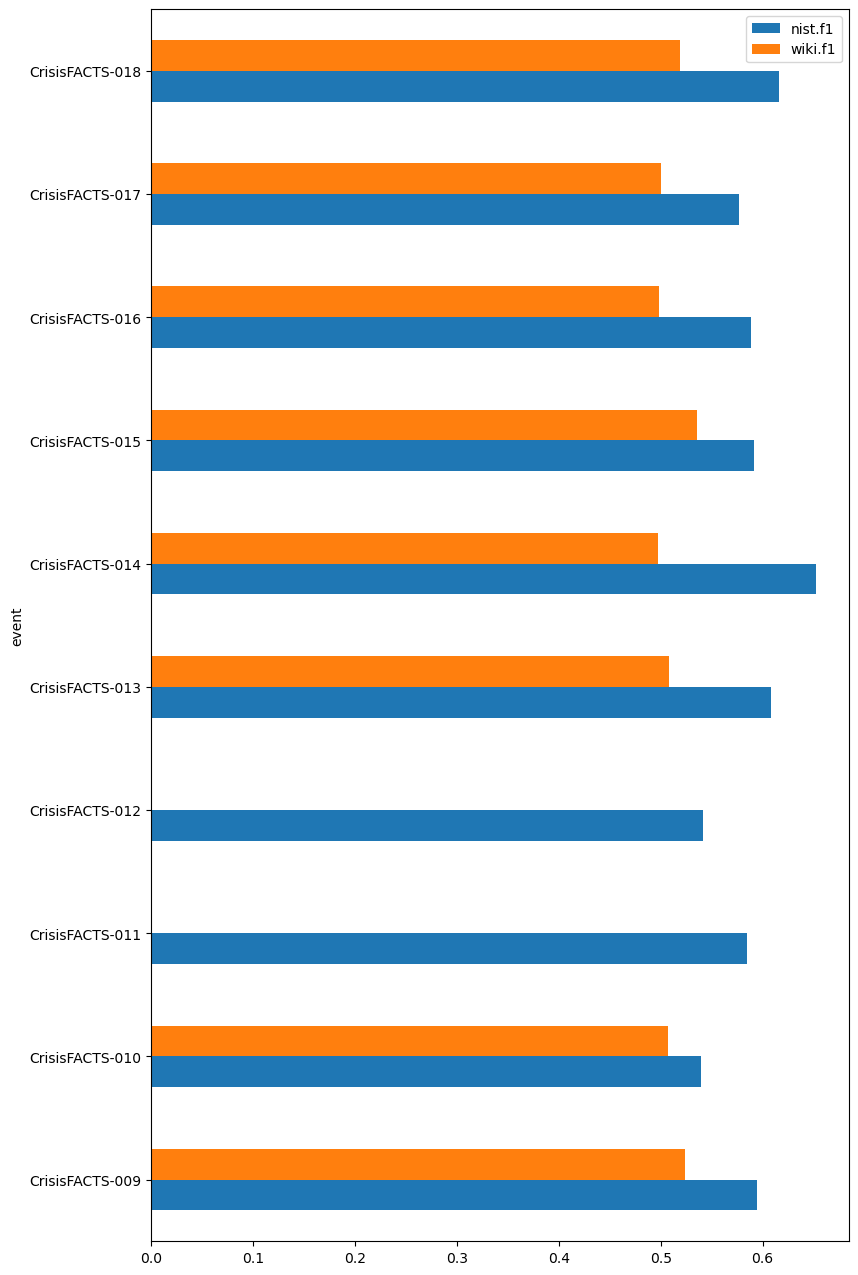

In [11]:
fig = plt.figure(figsize=(9,16))
ax = fig.add_subplot(1,1,1)

by_event_df[["nist.f1", "wiki.f1"]].plot.barh(ax=ax)

In [5]:
score_df = pd.read_csv("by_event.bertscore.summary.csv", index_col=0)
print(score_df.groupby("event").mean().style.to_latex())

In [7]:
print(score_df.groupby("event").mean().style.to_latex())

\begin{tabular}{lrrrrrr}
 & nist.f1 & nist.precision & nist.recall & wiki.f1 & wiki.precision & wiki.recall \\
event &  &  &  &  &  &  \\
CrisisFACTS-009 & 0.594496 & 0.583803 & 0.606239 & 0.524307 & 0.500297 & 0.551799 \\
CrisisFACTS-010 & 0.539738 & 0.537219 & 0.542816 & 0.507508 & 0.480131 & 0.538417 \\
CrisisFACTS-011 & 0.584929 & 0.584297 & 0.585698 & nan & nan & nan \\
CrisisFACTS-012 & 0.541760 & 0.537036 & 0.546708 & nan & nan & nan \\
CrisisFACTS-013 & 0.608627 & 0.609467 & 0.608022 & 0.507653 & 0.474955 & 0.545453 \\
CrisisFACTS-014 & 0.652125 & 0.658483 & 0.646350 & 0.497006 & 0.495349 & 0.498889 \\
CrisisFACTS-015 & 0.591514 & 0.590219 & 0.593328 & 0.535723 & 0.497754 & 0.580440 \\
CrisisFACTS-016 & 0.588953 & 0.587074 & 0.591479 & 0.498277 & 0.484401 & 0.513171 \\
CrisisFACTS-017 & 0.576741 & 0.571791 & 0.581963 & 0.500104 & 0.452149 & 0.559761 \\
CrisisFACTS-018 & 0.616166 & 0.619042 & 0.613623 & 0.518931 & 0.469754 & 0.580061 \\
\end{tabular}

